In [1]:
import os
features="duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label"
protocol_types = {"icmp":0,
"tcp":1,
"udp":2}
aggregated_labels = {"back":"dos",
"land":"dos",
"neptune":"dos",
"pod":"dos",
"smurf":"dos",
"teardrop":"dos",
"normal":"normal"}
deleted_labels = ["buffer_overflow",
"ftp_write",
"guess_passwd",
"imap",
"ipsweep",
"loadmodule",
"multihop",
"nmap",
"perl",
"phf",
"portsweep",
"rootkit",
"satan",
"spy",
"warezclient",
"warezmaster"]
service = {"auth":0,
"bgp":1,
"courier":2,
"csnet_ns":3,
"ctf":4,
"daytime":5,
"discard":6,
"domain":7,
"domain_u":8,
"echo":9,
"eco_i":10,
"ecr_i":11,
"efs":12,
"exec":13,
"finger":14,
"ftp":15,
"ftp_data":16,
"gopher":17,
"hostnames":18,
"http":19,
"http_443":20,
"imap4":21,
"IRC":22,
"iso_tsap":23,
"klogin":24,
"kshell":25,
"ldap":26,
"link":27,
"login":28,
"mtp":29,
"name":30,
"netbios_dgm":31,
"netbios_ns":32,
"netbios_ssn":33,
"netstat":34,
"nnsp":35,
"nntp":36,
"ntp_u":37,
"other":38,
"pm_dump":39,
"pop_2":40,
"pop_3":41,
"printer":42,
"private":43,
"red_i":44,
"remote_job":45,
"rje":46,
"shell":47,
"smtp":48,
"sql_net":49,
"ssh":50,
"sunrpc":51,
"supdup":52,
"systat":53,
"telnet":54,
"tftp_u":55,
"time":56,
"tim_i":57,
"urh_i":58,
"urp_i":59,
"uucp":60,
"uucp_path":61,
"vmnet":62,
"whois":63,
"X11":64,
"Z39_50":65}
flags = {"OTH":0,
"REJ":1,
"RSTO":2,
"RSTOS0":3,
"RSTR":4,
"S0":5,
"S1":6,
"S2":7,
"S3":8,
"SF":9,
"SH":10}

deleted_features = [42]
for i in range(10,23):
    deleted_features.append(i)
deleted_features.sort()
deleted_features.reverse()

file = open("D:\\kddcup.data_10_percent\\kddcup_data","r")

new_filename = "preprocessed_kddcup_data"
new_file = open(new_filename,"w")
new_file.write(features+"\n")

for line in file:
    line = line.replace("\n","")
    tokens = line.split(",")
    
    label = tokens[41]
    label = label.replace(".","")
    
    if label not in deleted_labels:
        label = aggregated_labels[label]
        
        tokens[1] = str(protocol_types[tokens[1]])
        tokens[2] = str(service[tokens[2]])
        tokens[3] = str(flags[tokens[3]])
        
        for i in deleted_features:
            tokens.pop(i-1)
          
        tokens.append(label)
        new_file.write(",".join(tokens) + "\n")

file.close()
new_file.close()

print("File created: " + new_filename)

File created: preprocessed_kddcup_data


Testing with full data
[+] Classifier trained in 755.58855509758
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00     97813
      normal       1.00      1.00      1.00     24371

    accuracy                           1.00    122184
   macro avg       1.00      1.00      1.00    122184
weighted avg       1.00      1.00      1.00    122184

[+] Model Evaluated in 1438.829567193985
[!] Test score is 0.9997626530478623
-------------------------------------------------
TP - True Negative 97801
FP - False Positive 17
FN - False Negative 12
TP - True Positive 24354
Accuracy Rate: 0.9997626530478623
Misclassification Rate: 0.00023734695213775944


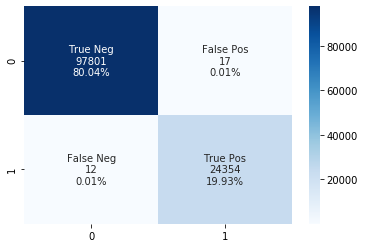

In [2]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
import seaborn as sns

def get_features(data):
	features = []
	for key in data.keys():
		features.append(key)
	features.remove("label")
	return features

def with_full_features(data):
    print("Testing with full data")
    
    features = get_features(data)
    X = data[features]
    y = data["label"]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
    
    knn = KNeighborsClassifier(n_neighbors = 5)
    
    start = time.time() 
    knn.fit(X_train,y_train)
    
    print("[+] Classifier trained in " + str(time.time() - start) )
    
    start = time.time()
    score = knn.score(X_test,y_test)
    
    y_pred = knn.predict(X_test)
    cm_train = metrics.classification_report(y_pred , y_test)
    print(cm_train)

    print("[+] Model Evaluated in " + str(time.time()-start) )
    print("[!] Test score is "  + str(score) )
    print( "-------------------------------------------------")
    
    cmat = metrics.confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cmat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cmat.flatten()/np.sum(cmat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cmat, annot=labels, fmt='', cmap='Blues')
    
    print('TP - True Negative {}'.format(cmat[0,0]))
    print('FP - False Positive {}'.format(cmat[0,1]))
    print('FN - False Negative {}'.format(cmat[1,0]))
    print('TP - True Positive {}'.format(cmat[1,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))


def main():
	filename="preprocessed_kddcup_data"
	data = pd.read_csv(filename)

	with_full_features(data)


main()